## Visualizing and filtering for missing data in VCF files

**20181219** NL

This notebook produces plots of missing data per individual and per locus, globally and within populations. The user can use these plots to evaluate what missing data thresholds they would like to use for filtering. Then, this notebook makes use of `vcftools` to filter out loci that exceed maximum missing data thresholds.

#### **[1]** Name inputs

In [191]:
vcf_file_dir = "/mnt/hgfs/E/Ipyrad/PC_allR_1M_20K_ref_001_outfiles/new_outfiles" # director containing the VCF file you will be using
vcf_filename = "PC_allR_1M_20K_ref_001_biall_maf.recode.vcf" # just file name (we're in the directory)
pop_asst_filepath = "/mnt/hgfs/E/Ipyrad/pop_assgn_files/PC_all_pop_assignment.txt" # absolute path 

basename = "PC_allR_1M_20K_ref_001_biall_maf" # Base name (of assembly, etc.) for naming output files

#### **[2]** Summarize population information

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os

os.chdir(vcf_file_dir)

# get time stamps
filename_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H-%M-%S') # print time stamp
readable_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S') # print time stamp

# make directory for new output files, if doesn't already exist & change wd into that dir
if not os.path.exists("MD_Vis_and_Filter-" + vcf_filename):
    os.makedirs("MD_Vis_and_Filter-" + vcf_filename)
os.chdir("MD_Vis_and_Filter-" + vcf_filename)

pop_asst_file = open(pop_asst_filepath, "r")

# dictionary to store population assignment information
# -> key is population name, value is list of individuals in the population
pop_asst_dict = {}

num_inds = 0
for line in pop_asst_file:
    linelist = line.strip().split()
    if linelist[1] not in pop_asst_dict:
        pop_asst_dict[linelist[1]] = []
    pop_asst_dict[linelist[1]].append(linelist[0])
    num_inds += 1
pop_asst_file.close()

pops_in_order = sorted(pop_asst_dict.keys())
ind_count_by_pop_fordf = []
for pop in pops_in_order:
    ind_count = len(pop_asst_dict[pop])
    ind_count_by_pop_fordf.append([pop, ind_count])
    
print("Total number of populations: " + str(len(pop_asst_dict)))
print("Total number of individuals: " + str(num_inds) + "\n\n")
    
header = ["Population","Num_individuals"]
ind_count_by_pop_df = pd.DataFrame(ind_count_by_pop_fordf, columns = header)
ind_count_by_pop_df

Total number of populations: 7
Total number of individuals: 289




,Population,Num_individuals
0,pop1,24
1,pop2,41
2,pop3,11
3,pop4,41
4,pop5,57
5,pop6,61
6,pop7,54


#### **[3]** Calculate & visualize missing data by locus (globally and by population) and by individual 

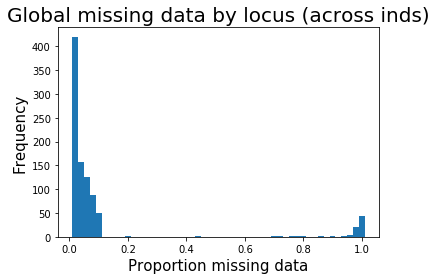

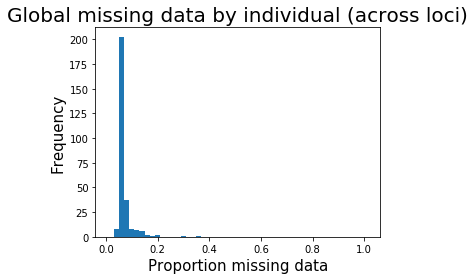

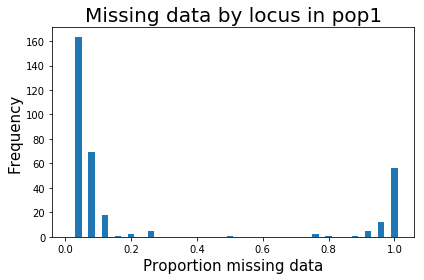

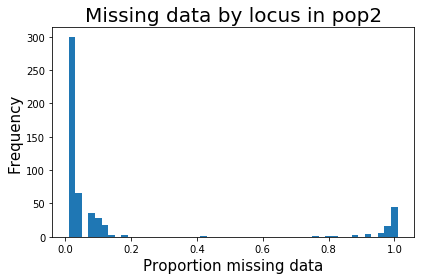

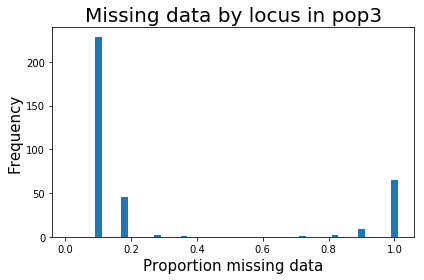

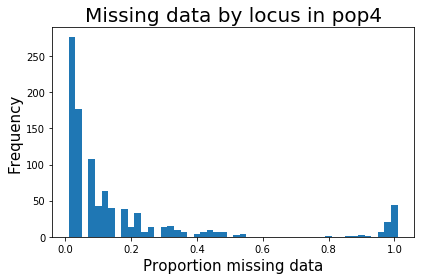

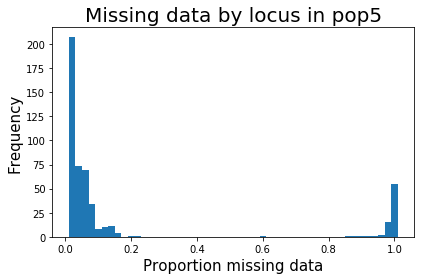

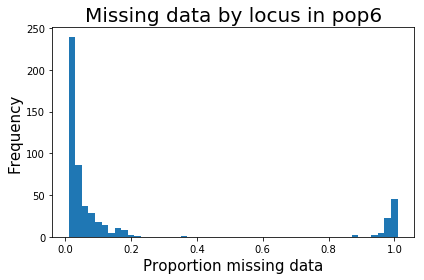

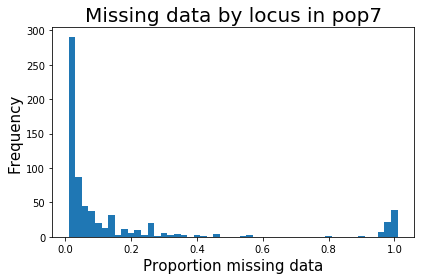

In [197]:
vcf_file = open("../" + vcf_filename, "r")

# initiate dictionaries to track missing data

# global locus missing data, by counts
# -> key is locus name, value is list with [count for missing data, count for having data]
glob_loc_md_cts = {} 

# global locus missing data, by proportion
# -> key is locus name, value is proportion of missing data, after iterating through all loci
glob_loc_md_prop = {}

# global individual (by index) missing data, by counts
# -> key is the index of the individual in the ordered set of individuals, value is list with [count for missing data, count for having data]
glob_ind_md_indx_cts = {}

# global individual missing data by proportion
# -> key is the index of the individual in the ordered set of individuals, value is proportion of missing data, after iterating through all loci
glob_ind_md_prop = {}

# population locus missing data, by counts
# -> key = locus name, value dictionary
# -> nested dict key = population name, value = missing data counts
pop_loc_md_cts = {} 

# population locus missing data, by proportion
# -> key = locus name, value dictionary
# -> nested dict key = population name, value = missing data counts
pop_loc_md_prop = {}

# individual index to population dictionary
# -> key is the individual index in the ordered set of indivdiuals from the VCF, value is the population name it belongs to
ind_idx_to_pop = {}

index = 0
for line in vcf_file:
    
    # store individual/sample names
    if line[0] == "#":
        if line[0:6] == "#CHROM":
            linelist = line.strip().split()
            inds_ordered = linelist[9:]
            for ind in inds_ordered:
                glob_ind_md_indx_cts[index] = [0,0] # initiate counters, [count for missing data, count for having data]
                index += 1
                
                # populate ind_idx_to_pop dictionary
                pop_asst_file = open(pop_asst_filepath, "r")
                for line in pop_asst_file:
                    linelist = line.strip().split()
                    if linelist[0] in inds_ordered:
                        current_index_a = inds_ordered.index(linelist[0])
                        ind_idx_to_pop [current_index_a] = linelist[1]
                pop_asst_file.close()
                
            
    # count missing data by locus and individual
    elif line[0] != "#":
        linelist = line.strip().split()
        genos = linelist[9:]
        locus_name = linelist[0] + "_" + linelist[1]
        glob_loc_md_cts[locus_name] = [0,0] # initiate counters, [count for missing data, count for having data]
        
        pop_loc_md_cts[locus_name] = {}
        for pop_name in pop_asst_dict.keys():
            pop_loc_md_cts[locus_name][pop_name] = [0,0] # initiate counters, [count for missing data, count for having data]
        
        current_index_b = 0
        for geno in genos:
            current_pop = ind_idx_to_pop[current_index_b]
            blocklist = geno.split(":")
            
            # count missing data by locus and by individual, globally and by population
            if blocklist[0] == "./.":
                glob_loc_md_cts[locus_name][0] += 1
                glob_ind_md_indx_cts[current_index_b][0] += 1
                pop_loc_md_cts[locus_name][current_pop][0] += 1 
            else:
                glob_loc_md_cts[locus_name][1] += 1
                glob_ind_md_indx_cts[current_index_b][1] += 1
                pop_loc_md_cts[locus_name][current_pop][1] += 1 
            current_index_b += 1
        
        # convert locus count missing data to proportion
        
        # globally
        locus_md_prop = (float(glob_loc_md_cts[locus_name][0])/(float(glob_loc_md_cts[locus_name][0]) + float(glob_loc_md_cts[locus_name][1])))
        glob_loc_md_prop[locus_name] = locus_md_prop
        
        # by population
        pop_loc_md_prop[locus_name] = {}
        for pop_name in pop_asst_dict.keys():
            pop_locus_md_prop = (float(pop_loc_md_cts[locus_name][pop_name][0])/(float(pop_loc_md_cts[locus_name][pop_name][0]) + float(pop_loc_md_cts[locus_name][pop_name][1])))
            pop_loc_md_prop[locus_name][pop_name] = pop_locus_md_prop
        
vcf_file.close()

# convert individual count missing data to proportion
for i in range(len(inds_ordered)):
    prop_ind_md = (float(glob_ind_md_indx_cts[i][0])/(float(glob_ind_md_indx_cts[i][0]) + float(glob_ind_md_indx_cts[i][1])))
    glob_ind_md_prop[inds_ordered[i]] = prop_ind_md
    
# visualize    
plt.hist(glob_loc_md_prop.values(), bins = np.arange(0,1.02,0.02)+0.01)
plt.title("Global missing data by locus (across inds)", size = 20)
plt.xlabel("Proportion missing data", size = 15)
plt.ylabel("Frequency", size = 15)
plt.tight_layout()
plt.savefig(basename + "_md_by_loc_" + filename_time + ".png", dpi = 300)
plt.show()

plt.hist(glob_ind_md_prop.values(), bins = np.arange(0,1.02,0.02)+0.01)
plt.title("Global missing data by individual (across loci)", size = 20)
plt.xlabel("Proportion missing data", size = 15)
plt.ylabel("Frequency", size = 15)
plt.tight_layout()
plt.savefig(basename+ "_md_by_ind_" + filename_time + ".png", dpi = 300)
plt.show()

pop_md = {}
for this_pop in pops_in_order:
    pop_md[this_pop] = []
for locus in glob_loc_md_cts.keys():
    for this_pop in pops_in_order:
        pop_md[this_pop].append(pop_loc_md_prop[locus][this_pop])
        
for this_pop in pops_in_order:
    plt.hist(pop_md[this_pop], bins = np.arange(0,1.02,0.02)+0.01)
    plt.title("Missing data by locus in " + this_pop, size = 20)
    plt.xlabel("Proportion missing data", size = 15)
    plt.ylabel("Frequency", size = 15)
    plt.tight_layout()
    plt.savefig(basename + "_md_by_loc_" + this_pop + "_" + filename_time + ".png", dpi = 300)
    plt.show() 

#### **[4]** Set thresholds for filtering missing data


In [189]:
# Maximum proportion of missing data allowed across all individuals and populations
max_md_per_locus_global = 0.15

# Maximum missing data allowed per locus within a population
max_md_per_locus_bypop = 0.15

# Minimum number of populations a locus must be genotyped in with the max missing data per pop threshold to be kept
min_pops_obs = 3

# Maximum missing data allowed per individual across loci
max_md_per_ind = 0.15


#### **[5]** Identify loci and individuals to keep and lose

In [176]:
# initiate lists to track which loci will get filtered out and which will be kept
loci_to_keep = []
for locus in glob_loc_md_cts.keys():
    loci_to_keep.append(locus)
loci_to_lose = []

# apply filtering thresholds, and update lists with loci to filter out and keep
for locus in glob_loc_md_prop.keys():
    if glob_loc_md_prop[locus] > max_md_per_locus_global:
        loci_to_keep.remove(locus)
        loci_to_lose.append(locus)
        
    pass_pop_md_thresh = 0 # counter that tracks number of populations where a locus meets the per pop missing data threshold
    for pop in pops_in_order:
        if pop_loc_md_prop[locus][pop] <= max_md_per_locus_bypop:
            pass_pop_md_thresh += 1
    if pass_pop_md_thresh < min_pops_obs:
        if locus in loci_to_keep:
            loci_to_keep.remove(locus)
        if locus not in loci_to_lose:
            loci_to_lose.append(locus)  
            
# write loci output files
loci_keep_out = open(basename + "_loci_to_keep.txt","w")
for locus in loci_to_keep:
    locus_name_list = locus.split("_")
    locus_line = locus_name_list[0] + "_" + locus_name_list[1] + "\t" + locus_name_list[2]
    loci_keep_out.write(locus_line + "\n")
loci_keep_out.close()
loci_lose_out = open(basename + "_loci_to_lose.txt","w")
loci_lose_out_forVCF = open(basename + "_loci_to_lose_forVCF.txt", "w")
for locus in loci_to_lose:
    loci_lose_out.write(locus + "\n")
    locus_name_list = locus.split("_")
    locus_line = locus_name_list[0] + "_" + locus_name_list[1] + "\t" + locus_name_list[2]
    loci_lose_out_forVCF.write(locus_line + "\n")
loci_lose_out.close()
loci_lose_out_forVCF.close()
            
# initiate lists to track which inds will get filtered out and which will be kept
inds_to_keep = []
for ind in inds_ordered:
    inds_to_keep.append(ind)
inds_to_lose = []
            
for ind in inds_ordered:
    if glob_ind_md_prop[ind] > max_md_per_ind:
        inds_to_keep.remove(ind)
        inds_to_lose.append(ind)

# write inds output files
inds_keep_out = open(basename + "_inds_to_keep.txt","w")
for ind in inds_to_keep:
    inds_keep_out.write(ind + "\n")
inds_keep_out.close()
inds_lose_out = open(basename + "_inds_to_lose.txt","w")
for ind in inds_to_lose:
    inds_lose_out.write(ind + "\n")
inds_lose_out.close()
            
# let user know how many loci will be kept and lost
print("LOCI")
print("This notebook will filter out " + str(len(loci_to_lose)) + " loci." )
print("After filtering, your data set will include " + str(len(loci_to_keep)) + " loci.\n")
print("INDIVIDUALS")
print("This notebook will filter out " + str(len(inds_to_lose)) + " individuals.")
print("After filtering, your data set will include " + str(len(inds_to_keep)) + " individuals.\n")

LOCI
This notebook will filter out 79 loci.
After filtering, your data set will include 1483 loci.

INDIVIDUALS
This notebook will filter out 7 individuals.
After filtering, your data set will include 268 individuals.



#### **[6]** Use vcftools to filter 

In [178]:
import subprocess as sp
vcf_call = "vcftools --vcf ../" + vcf_filename + " "
vcf_call += "--exclude-positions " + basename + "_loci_to_lose_forVCF.txt "
vcf_call += "--remove " + basename + "_inds_to_lose.txt "
vcf_call += "--out " + basename + "_md "
vcf_call += "--recode-INFO-all --recode"
sp.call([vcf_call],shell=True)

# check vcf log, make sure it filtered as expected
vcf_log = open(basename + "_md.log", "r")
for line in vcf_log:
    print(line)
vcf_log.close()



VCFtools - 0.1.15

(C) Adam Auton and Anthony Marcketta 2009



Parameters as interpreted:

	--vcf ../PC_allR_1M_20K_ref_001_biall_maf.recode.vcf

	--exclude-positions PC_allR_1M_20K_ref_001_biall_maf_loci_to_lose_forVCF.txt

	--remove PC_allR_1M_20K_ref_001_biall_maf_inds_to_lose.txt

	--recode-INFO-all

	--out PC_allR_1M_20K_ref_001_biall_maf_md

	--recode



Excluding individuals in 'exclude' list

After filtering, kept 268 out of 275 Individuals

Outputting VCF file...

After filtering, kept 1483 out of a possible 1562 Sites

Run Time = 1.00 seconds



#### **[7]** Make a log that tracks what happened in this notebook run

In [198]:
log = open(basename + "_md_log.txt" , "w")
log_string = "### Missing data visualiation and filtering notebook " + "\n\n"
log_string += "Timestamp: " + readable_time + "\n"
log_string += "VCF file used: " + vcf_filename + "\n"
log_string += "Population assignment file used: " + pop_asst_filepath.split("/")[-1] + "\n\n"
log_string += "Missing data filtering thresholds: \n"
log_string += "Max missing data per individual across loci = " + str(max_md_per_ind) + "\n"
log_string += "Max missing data per locus across individuals = " + str(max_md_per_locus_global) + "\n"
log_string += "Max missing data per locus within populations = " + str(max_md_per_locus_bypop) + "\n"
log_string += "Minimum number of populations a locus must be genotyped in, within max data per population threshold, to be kept = " + str(min_pops_obs) + "\n\n"
log_string += "This notebook will filter out " + str(len(loci_to_lose)) + " loci.\n"
log_string += "After filtering, your data set will include " + str(len(loci_to_keep)) + " loci.\n"
log_string += "This notebook will filter out " + str(len(inds_to_lose)) + " individuals.\n"
log_string += "After filtering, your data set will include " + str(len(inds_to_keep)) + " individuals.\n\n"

log.write(log_string)
log.close()          
          